**Notes**:
- Should we buffer the actual building or the centroid?  Buffering the centroid could cause an erroneous result because the building footprint is larger than the buffer from the centroid.


In [1]:
import os

import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt

import naturf

data_dir = "/Users/d3y010/projects/naturf/data"

input_shapefile = os.path.join(data_dir, "inputs", "C-5.shp")

model = naturf.Model(input_shapefile)

gxf = model.generate()


In [2]:
gxf.shape

(9324, 2)

In [3]:
gxf.head()

,distance_to_neighbor,angle_in_degrees_to_neighbor
0,0.000000,0.000000
0,15.126073,90.630695
1,15.126073,270.630695
1,0.000000,0.000000
2,0.000000,0.000000


In [4]:
gxf.sort_values(by="building_id_target")

,distance_to_neighbor,building_height_target,building_height_neighbor,building_id_target,building_id_neighbor,building_area_target,building_area_neighbor,building_polygon_geometry_target,building_polygon_geometry_neighbor
0,0.000000,2.66,2.66,132230,132230,320.512854,320.512854,"POLYGON ((1618052.020 1922797.834, 1618051.749...","POLYGON ((1618052.020 1922797.834, 1618051.749..."
0,15.126073,2.66,2.66,132230,132237,320.512854,34.959333,"POLYGON ((1618052.020 1922797.834, 1618051.749...","POLYGON ((1618059.647 1922806.024, 1618058.415..."
1,15.126073,2.66,2.66,132237,132230,34.959333,320.512854,"POLYGON ((1618059.647 1922806.024, 1618058.415...","POLYGON ((1618052.020 1922797.834, 1618051.749..."
1,0.000000,2.66,2.66,132237,132237,34.959333,34.959333,"POLYGON ((1618059.647 1922806.024, 1618058.415...","POLYGON ((1618059.647 1922806.024, 1618058.415..."
2,0.000000,25.41,25.41,132338,132338,8241.992817,8241.992817,"POLYGON ((1620424.742 1923453.039, 1620423.981...","POLYGON ((1620424.742 1923453.039, 1620423.981..."
...,...,...,...,...,...,...,...,...,...
191,89.651255,7.28,4.95,163411,157051,2948.264256,42.242959,"POLYGON ((1619357.797 1923445.956, 1619344.502...","POLYGON ((1619445.248 1923345.231, 1619443.257..."
191,93.208569,7.28,4.95,163411,159784,2948.264256,6.565565,"POLYGON ((1619357.797 1923445.956, 1619344.502...","POLYGON ((1619442.911 1923341.729, 1619441.670..."
191,121.374729,7.28,13.04,163411,140294,2948.264256,121.603499,"POLYGON ((1619357.797 1923445.956, 1619344.502...","POLYGON ((1619458.879 1923517.532, 1619458.491..."
191,172.370094,7.28,4.45,163411,137043,2948.264256,225.367914,"POLYGON ((1619357.797 1923445.956, 1619344.502...","POLYGON ((1619230.693 1923364.655, 1619231.822..."


<AxesSubplot:>

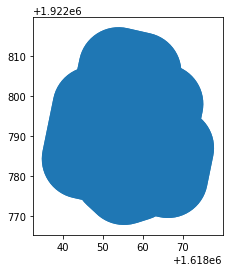

In [14]:
gpd.GeoSeries(gxf.building_polygon_geometry_target.iloc[0:4], crs=gxf.target_crs.unique()[0]).buffer(10, cap_style=3).plot()

<AxesSubplot:>

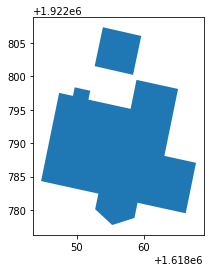

In [7]:
gpd.GeoSeries(gxf.building_polygon_geometry.iloc[0:2], crs=gxf.target_crs.unique()[0]).plot()

<AxesSubplot:>

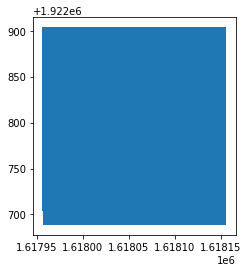

In [8]:
gpd.GeoSeries(gxf.building_centroid_buffered.iloc[0:2], crs=gxf.target_crs.unique()[0]).plot()

# Notes
- When changing from using the area as calculated from the raster grids to using the raw geometry, the area is different



# TODO
- ignore the target building in the statistics
- for building areas and heigts include the target
- [**done**] for the 0 heights, exclude out 0 height or 0 area values (when reading in shapefile - do this as filter)
- don't need the pickle files: do need binary file for WRF, index file for WRF, CSV for breakdown via params, TIFs for diagnostic evaluation so rasterize the polygon output
- add new parameter :: skyview :: either 101 or 102


# Flat process

In [5]:
data_dir = "/Users/d3y010/projects/naturf/data"


input_shapefile = os.path.join(data_dir, "inputs", "C-5.shp")
raster_dir = os.path.join(data_dir, "outputs")

latitude_center = 38.9
longitude_center = -77.0

id_field = "OBJECTID"
height_field = "Max_HOUSE_"
area_field = "area"
sequential_id_field = "xid"
geometry_field = "geometry"

raster_value = 127
no_data_value = 255
target_resolution = 0.5

radius = 100

raster_ids_file = os.path.join(data_dir, "example_naturf_outputs_v2", "Chris_and_Emily_C-5", "Tifs", "Building_IDs.tif")

NORTHWEST_DEGREES = 135
NORTHEAST_DEGREES = 45
SOUTHWEST_DEGREES = 225
SOUTHEAST_DEGREES = 315
DEGREES_IN_CIRCLE = 360
START_OF_CIRCLE_DEGREES = 0

BUILDING_HEIGHT_INTERVAL = 5
CONSTANT_NEG_04 = -0.4
CONSTANT_0193 = 0.193
CONSTANT_0303 = 0.303
CONSTANT_359 = 3.59
CONSTANT_15 = 15
DEGREES_IN_CIRCLE = 360
DILAREA_DEFAULT = 10000
DISPLACEMENT_HEIGHT_FACTOR = 0.67
MAX_BUILDING_HEIGHT = 75
NORTHEAST_DEGREES = 45
NORTHWEST_DEGREES = 135
RADIUS = 100
RDH_THRESHOLD_MAX = 3
RDH_THRESHOLD_MIN = 0 
ROUGHNESS_LENGTH_FACTOR = 0.1
RRL_THRESHOLD_MAX = 3
RRL_THRESHOLD_MIN = 0
SMALL_DECIMAL = 0.0000000000000000000000000000001
SOUTHEAST_DEGREES = 315
SOUTHWEST_DEGREES = 225
START_OF_CIRCLE_DEGREES = 0
ZXCV_FACTOR = 3.5


In [6]:
%%time

# read in shapefile and only keep necessary fields
gdf = gpd.read_file(input_shapefile)[[id_field, height_field, geometry_field]]

# calculate the actual building area
gdf[area_field] = gdf.geometry.area

# filter out any 0 height or 0 area buildings and reindex the data frame
gdf = gdf.loc[(gdf[height_field] > 0) & (gdf[area_field] > 0)].reset_index(drop=True)

# create a field representing the centroid of the polygon
gdf["centroid"] = gdf.geometry.centroid

# create a field with the buffered building
gdf["buffered"] = gdf.geometry.centroid.buffer(distance=radius, cap_style=3)

# conduct a spatial join to get the building centroids that intersect the buffered target buildings
gdf = gpd.sjoin(left_df=gpd.GeoDataFrame(gdf[[id_field, height_field, area_field, geometry_field, "centroid", "buffered"]], crs=gdf.crs, geometry="buffered"), 
                right_df=gpd.GeoDataFrame(gdf[[id_field, height_field, area_field, "centroid"]], crs=gdf.crs, geometry="centroid"), 
                how="left", 
                predicate='intersects',
                lsuffix="target",
                rsuffix="neighbors")

# reset the geometry field as the original building geometry
gdf.set_geometry("geometry", inplace=True, crs=gdf.crs)

# modified field name variables after merge
target_height_field = f"{height_field}_target"
neighbor_height_field = f"{height_field}_neighbors"
target_id_field = f"{id_field}_target"
neighbor_id_field = f"{id_field}_neighbors"
target_area_field = f"{area_field}_target"
neighbor_area_field = f"{area_field}_neighbors"

# generate the building centroid of each neighbor building
gdf["neighbor_centroid"] = gpd.GeoSeries(gdf[neighbor_id_field].map(gdf.groupby(target_id_field)["centroid"].first()), crs=gdf.crs)

# calculate the distance from the target building neighbor to each neighbor building centroid
gdf["distance"] = gdf.geometry.centroid.distance(gdf["neighbor_centroid"])

# calculate the angle in degrees of the neighbor building orientation to the target
gdf["angle_in_degrees"] = np.degrees(np.arctan2(gdf["neighbor_centroid"].y - gdf["centroid"].y, gdf["neighbor_centroid"].x - gdf["centroid"].x))

# adjust the angle to correspond to a circle where 0/360 degrees is directly east, and the degrees increase counter-clockwise
gdf["angle_in_degrees"] = np.where(gdf["angle_in_degrees"] < 0, 
                                   gdf["angle_in_degrees"] + DEGREES_IN_CIRCLE, 
                                   gdf["angle_in_degrees"])

# identify east-west orientation
gdf["direction"] = np.where((((SOUTHEAST_DEGREES <= gdf["angle_in_degrees"]) & (gdf["angle_in_degrees"] <= DEGREES_IN_CIRCLE)) 
                            | ((START_OF_CIRCLE_DEGREES <= gdf["angle_in_degrees"]) & (gdf["angle_in_degrees"] < NORTHEAST_DEGREES)))
                            | ((NORTHWEST_DEGREES <= gdf["angle_in_degrees"]) & (gdf["angle_in_degrees"] < SOUTHWEST_DEGREES)),
                           "east_west",
                           "")

# identify north-south orientation
gdf["direction"] = np.where(((NORTHEAST_DEGREES <= gdf["angle_in_degrees"]) & (gdf["angle_in_degrees"] < NORTHWEST_DEGREES))
                            | ((SOUTHWEST_DEGREES <= gdf["angle_in_degrees"]) & (gdf["angle_in_degrees"] < SOUTHEAST_DEGREES)),
                           "north_south",
                           gdf["direction"])

# calculate the area of all buildings within the plan area
plan_area_dict = gdf.groupby(target_id_field)[neighbor_area_field].sum().to_dict()

# building height
building_height_dict = gdf.groupby(target_id_field)[target_height_field].max().to_dict()

# add the height and plan_area to a dictonary where the key is the target building ID
footprint_building_areas = {i: [building_height_dict[i], plan_area_dict[i]] for i in plan_area_dict.keys()}

# average building heights for each target building when considering themselves and those that are within their buffered area
average_building_heights = gdf.groupby(target_id_field)[neighbor_height_field].mean().fillna(0).tolist()

# standard deviation for building heights for each target building when considering themselves and those that are within their buffered area
standard_deviation_building_heights = gdf.groupby(target_id_field)[neighbor_height_field].std().fillna(0).tolist()

# calculate the average directional distances for each target building to its neighbors
average_direction_distance = gdf.groupby([target_id_field, "direction"])["distance"].mean().reset_index()

# exclude the target building to target building distance and direction (would be == 0)
average_direction_distance = average_direction_distance.loc[average_direction_distance["distance"] > 0]

# TODO:  ensure that there is a distance recorded for both east-west and north-south measurements

# initialize dictionaries with 0 for each target building
average_north_south_building_distances = {i: 0 for i in np.sort(gdf[target_id_field].unique())}
average_east_west_building_distances = average_north_south_building_distances.copy()

# update dictionaries where values exists
average_north_south_building_distances.update(average_direction_distance.loc[average_direction_distance["direction"] == "north_south"][[target_id_field, "distance"]].set_index(target_id_field).to_dict()["distance"])
average_east_west_building_distances.update(average_direction_distance.loc[average_direction_distance["direction"] == "east_west"][[target_id_field, "distance"]].set_index(target_id_field).to_dict()["distance"])

# calculate the building area * height for each neighbor building
gdf["neighbor_volume"] = gdf[neighbor_area_field] * gdf[neighbor_height_field]

# calculate the area weighted building heights and replace any inf and nan with 0 (these come from 0 areas where height is 0)
area_weighted_average_building_heights = ((gdf.groupby(target_id_field)["neighbor_volume"].sum()) / 
                                          (gdf.groupby(target_id_field)[neighbor_area_field].sum())
                                         ).replace([np.inf, -np.inf], 0).fillna(0).to_list()

# average of all of the building surface areas in the shapefile
average_building_area = gdf.groupby(target_id_field)[target_area_field].max().mean()

gdf.loc[gdf[target_id_field] == 132230]



CPU times: user 125 ms, sys: 6.45 ms, total: 131 ms
Wall time: 131 ms


In [7]:
gdf.shape

(9368, 10)

In [9]:
gdf.sort_values(by="OBJECTID_target")

,OBJECTID_target,Max_HOUSE__target,area_target,geometry,centroid,buffered,index_neighbors,OBJECTID_neighbors,Max_HOUSE__neighbors,area_neighbors
0,132230,2.66,320.512854,"POLYGON ((1618052.020 1922797.834, 1618051.749...",POINT (1618056.329 1922788.642),"POLYGON ((1618156.329 1922888.642, 1618156.329...",0,132230,2.66,320.512854
0,132230,2.66,320.512854,"POLYGON ((1618052.020 1922797.834, 1618051.749...",POINT (1618056.329 1922788.642),"POLYGON ((1618156.329 1922888.642, 1618156.329...",1,132237,2.66,34.959333
1,132237,2.66,34.959333,"POLYGON ((1618059.647 1922806.024, 1618058.415...",POINT (1618056.162 1922803.767),"POLYGON ((1618156.162 1922903.767, 1618156.162...",0,132230,2.66,320.512854
1,132237,2.66,34.959333,"POLYGON ((1618059.647 1922806.024, 1618058.415...",POINT (1618056.162 1922803.767),"POLYGON ((1618156.162 1922903.767, 1618156.162...",1,132237,2.66,34.959333
2,132338,25.41,8241.992817,"POLYGON ((1620424.742 1923453.039, 1620423.981...",POINT (1620397.530 1923516.071),"POLYGON ((1620497.530 1923616.071, 1620497.530...",2,132338,25.41,8241.992817
...,...,...,...,...,...,...,...,...,...,...
191,163411,7.28,2948.264256,"POLYGON ((1619357.797 1923445.956, 1619344.502...",POINT (1619390.113 1923419.337),"POLYGON ((1619490.113 1923519.337, 1619490.113...",17,134777,4.95,1533.406866
191,163411,7.28,2948.264256,"POLYGON ((1619357.797 1923445.956, 1619344.502...",POINT (1619390.113 1923419.337),"POLYGON ((1619490.113 1923519.337, 1619490.113...",48,139162,7.43,138.198447
191,163411,7.28,2948.264256,"POLYGON ((1619357.797 1923445.956, 1619344.502...",POINT (1619390.113 1923419.337),"POLYGON ((1619490.113 1923519.337, 1619490.113...",168,156500,2.60,46.412548
191,163411,7.28,2948.264256,"POLYGON ((1619357.797 1923445.956, 1619344.502...",POINT (1619390.113 1923419.337),"POLYGON ((1619490.113 1923519.337, 1619490.113...",96,151264,9.21,72.015843


### Explore the input data

In [2]:
data_dir = "/Users/d3y010/projects/naturf/data"

input_shapefile = os.path.join(data_dir, "inputs", "C-5.shp")


In [4]:
# read in shapefile and take a look
gdf = gpd.read_file(input_shapefile)


In [5]:
gdf.head(3)

,Join_Count,TARGET_FID,FID_1,OBJECTID,GIS_ID,FEATURECOD,DESCRIPTIO,CAPTUREYEA,CAPTUREACT,SHAPE_Leng,...,Col,Row,Let_To_Num,First_Inde,Second_Ind,First_In_1,Second_I_1,Shape_Le_1,Shape_Area,geometry
0,1,132147,132146,132147,None,BUILDING,Building,2015-04-24T00:00:00.000Z,Existing,12.991845,...,C,5.0,3.0,65.0,96.0,65.0,96.0,13.001421,10.433831,"POLYGON ((1618111.652 1922706.443, 1618109.381..."
1,1,132186,132185,132186,None,BUILDING,Building,2015-04-24T00:00:00.000Z,Existing,25.555249,...,C,5.0,3.0,65.0,96.0,65.0,96.0,25.553881,37.983140,"POLYGON ((1618092.351 1922752.255, 1618088.410..."
2,1,132230,132229,132230,None,BUILDING,Building,2017-03-09T00:00:00.000Z,Update,88.360518,...,C,5.0,3.0,65.0,96.0,65.0,96.0,88.376402,320.512854,"POLYGON ((1618052.020 1922797.834, 1618051.749..."


<AxesSubplot:>

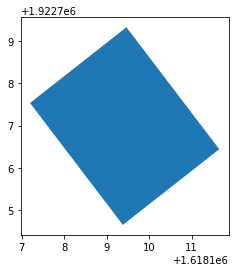

In [5]:
# plot one of the polygons
gdf.loc[gdf["TARGET_FID"] == 132147].plot()


In [12]:
# take a look at the coordinate reference system
gdf.crs


<Derived Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

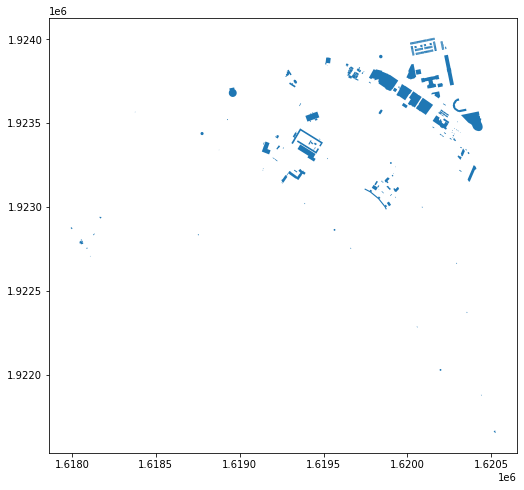

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

gdf.plot(ax=ax)


## Original code

In [1]:
import os

import numpy as np
from rasterio.plot import show
from osgeo import gdal, ogr, osr
from skimage.draw import polygon



In [2]:
data_dir = "/Users/d3y010/projects/naturf/data"

input_shapefile = os.path.join(data_dir, "inputs", "C-5.shp")
raster_dir = os.path.join(data_dir, "outputs")
latitude_center = 38.9
longitude_center = -77.0
id_field = "OBJECTID"
height_field = "Max_HOUSE_"


In [3]:
driver = ogr.GetDriverByName('ESRI Shapefile')


In [4]:
datasource2 = driver.Open(input_shapefile, 0)


In [5]:
gdal.AllRegister()


In [6]:
layer2 = datasource2.GetLayer()


In [7]:
extent2 = layer2.GetExtent()

extent2


(1617992.0141000003, 1620526.423200001, 1921653.0683999993, 1924009.7564999992)

In [8]:
xOrigin = extent2[0]
yOrigin = extent2[3]

xOrigin, yOrigin


(1617992.0141000003, 1924009.7564999992)

In [9]:
PIXEL_SIZE = 0.5

IMAGE_SIZE_X = int((2 * np.ceil(extent2[3]-extent2[2])) + 100)
IMAGE_SIZE_Y = int((2 * np.ceil(extent2[1]-extent2[0])) + 100)

pixelWidth = PIXEL_SIZE
pixelHeight = -PIXEL_SIZE

IMAGE_SIZE_X, IMAGE_SIZE_Y


(4814, 5170)

In [10]:
start_x = int(xOrigin)
start_y = np.ceil(yOrigin)

start_x_p = int((start_x - xOrigin) / pixelWidth)
start_y_p = int((start_y - yOrigin) / pixelHeight)

start_x_p, start_y_p


(0, 0)

In [11]:
driver_out = gdal.GetDriverByName('GTiff')


#### NOTE: potential error in passing Y size into xsize argument position

In [12]:
help(driver_out.Create)

Help on method Create in module osgeo.gdal:

Create(*args, **kwargs) method of osgeo.gdal.Driver instance
    Create(Driver self, char const * utf8_path, int xsize, int ysize, int bands=1, GDALDataType eType=GDT_Byte, 
        char ** options=None) -> Dataset



Alternate possibility:

```python
imgOut = driver_out.Create(utf8_path=os.path.join(raster_dir, 'Buildings_Raster.tif'), 
                           ysize=IMAGE_SIZE_Y, 
                           xsize=IMAGE_SIZE_X, 
                           bands=1, 
                           eType=gdal.GDT_Int32)
```

In [13]:
imgOut = driver_out.Create(os.path.join(raster_dir, 'Buildings_Raster.tif'), 
                           IMAGE_SIZE_Y, 
                           IMAGE_SIZE_X, 
                           1, 
                           gdal.GDT_Int32)


In [14]:
proj = osr.SpatialReference()
proj.SetWellKnownGeogCS("NAD1983")
proj.SetACEA(29.5, 45.5, latitude_center, longitude_center, 0, 0)


0

In [15]:
bandOut1 = imgOut.GetRasterBand(1)

data1 = np.empty((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=np.uint8)
data1.fill(255)

ids = np.empty((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=np.uint16)
ids.fill(255)

buils = np.empty((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=np.uint16)
buils.fill(255)

tempxyz = np.empty((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=np.float64)

distarr = np.empty((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=np.float64)
distarr.fill(0)


#### ------------ BEGIN Option 1:  run full loop ------------


In [16]:
# loop through the buildings
feature_buil = layer2.GetNextFeature()

while feature_buil:
    
    geomb = feature_buil.GetGeometryRef()
    ring = geomb.GetGeometryRef(0)
    numpoints = ring.GetPointCount()
    
    if numpoints != 0:
    
        nx, ny, _ = ring.GetPoint(0)

        xOffset = int((nx - xOrigin) / pixelWidth)
        yOffset = int((ny - yOrigin) / pixelHeight)

        parrx = [[xOffset]]
        parry = [[yOffset]]

        for i in range(1, numpoints):

            bpt = ring.GetPoint(i)

            xoff = int((bpt[0] - xOrigin) / pixelWidth)
            yoff = int((bpt[1] - yOrigin) / pixelHeight)

            parrx.append([xoff])
            parry.append([yoff])

        parrx[:] = [x[0] - start_x_p for x in parrx]
        parry[:] = [y[0] - start_y_p for y in parry]

        parrx = np.array(parrx)
        parry = np.array(parry)

        rr, cc = polygon(parrx, parry, [IMAGE_SIZE_Y, IMAGE_SIZE_X])

        buils[cc, rr] = 127

    feature_buil.Destroy()
    feature_buil = layer2.GetNextFeature()


#### ------------ END Option 1:  run full loop ------------


#### ------------ BEGIN Option 2: break loop into parts to evaluate ------------

In [ ]:
# loop through the buildings
feature_buil = layer2.GetNextFeature()

#### [0] START LOOP

In [31]:
geomb = feature_buil.GetGeometryRef()
ring = geomb.GetGeometryRef(0)
numpoints = ring.GetPointCount()


In [32]:
ring

<osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x1166a4390> >

In [33]:
numpoints

9

In [34]:
nx, ny, _ = ring.GetPoint(0)

nx, ny, _

(1618111.6521999985, 1922706.4426000006, 0.0)

In [35]:
xOffset = int((nx - xOrigin) / pixelWidth)
yOffset = int((ny - yOrigin) / pixelHeight)

xOffset, yOffset


(239, 2606)

In [37]:
parrx = [[xOffset]]
parry = [[yOffset]]

parrx, parry


([[239]], [[2606]])

In [38]:
for i in range(1, numpoints):
    
    bpt = ring.GetPoint(i)
    
    print(bpt)

    xoff = int((bpt[0] - xOrigin) / pixelWidth)
    yoff = int((bpt[1] - yOrigin) / pixelHeight)

    parrx.append([xoff])
    parry.append([yoff])

parrx, parry


(1618109.3806000017, 1922704.6578000002, 0.0)
(1618108.8795999996, 1922705.3160999995, 0.0)
(1618107.362399999, 1922707.3079000004, 0.0)
(1618107.1928000003, 1922707.5310999993, 0.0)
(1618109.4642000012, 1922709.3165000007, 0.0)
(1618109.5769000016, 1922709.1688, 0.0)
(1618111.2226999998, 1922707.0072000008, 0.0)
(1618111.6521999985, 1922706.4426000006, 0.0)


([[239], [234], [233], [230], [230], [234], [235], [238], [239]],
 [[2606], [2610], [2608], [2604], [2604], [2600], [2601], [2605], [2606]])

In [39]:
parrx[:] = [x[0] - start_x_p for x in parrx]
parry[:] = [y[0] - start_y_p for y in parry]

parrx, parry


([239, 234, 233, 230, 230, 234, 235, 238, 239],
 [2606, 2610, 2608, 2604, 2604, 2600, 2601, 2605, 2606])

In [43]:
parrx = np.array(parrx)
parry = np.array(parry)

rr, cc = polygon(parrx, parry, [IMAGE_SIZE_Y, IMAGE_SIZE_X])

buils[cc, rr] = 127

buils


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint16)

In [44]:
buils.shape

(4814, 5170)

In [46]:
feature_buil.Destroy()
feature_buil = layer2.GetNextFeature()


#### [0] END LOOP

#### ------------ END Option 2: break loop into parts to evaluate ------------

In [17]:
data1 = np.where(buils != 127, data1, 127)


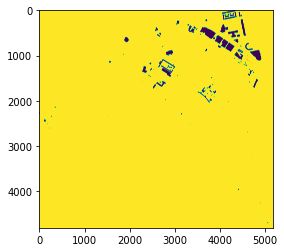

<AxesSubplot:>

In [18]:
show(data1)

In [19]:
bandOut1.WriteArray(data1, 0, 0)

imgOut.SetGeoTransform((start_x, pixelWidth, 0, start_y, 0, pixelHeight))

imgOut.SetProjection(proj.ExportToWkt())

del imgOut


## Implementation process

In [3]:
import os

import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from geocube.api.core import make_geocube

import matplotlib.pyplot as plt


In [4]:
data_dir = "/Users/d3y010/projects/naturf/data"

input_shapefile = os.path.join(data_dir, "inputs", "C-5.shp")
raster_dir = os.path.join(data_dir, "outputs")
latitude_center = 38.9
longitude_center = -77.0
id_field = "OBJECTID"
height_field = "Max_HOUSE_"

raster_value = 127
no_data_value = 255
target_resolution = 0.5


In [5]:
# read in shapefile as a geodataframe
gdf = gpd.read_file(input_shapefile)


In [6]:
# add in field for raster value
gdf["raster_value"] = raster_value


See docs for the `make_geocube` function here:  https://corteva.github.io/geocube/stable/geocube.html?highlight=make_geocube#make-geocube

In [7]:
cube = make_geocube(vector_data=gdf, 
                    measurements=["raster_value"], 
                    resolution=(target_resolution, -target_resolution),
                    fill=no_data_value)


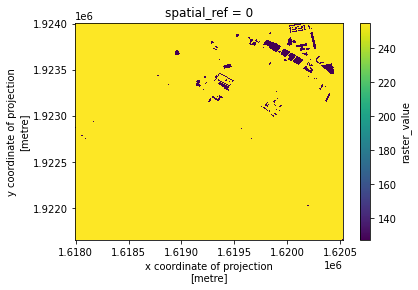

In [8]:
cube.raster_value.plot()

In [9]:
output_raster = os.path.join(raster_dir, f"buildings_{os.path.splitext(os.path.basename(input_shapefile))[0]}.tif")

cube.raster_value.rio.to_raster(output_raster)
                             

In [10]:
cube


<xarray.Dataset>
Dimensions:       (y: 4714, x: 5069)
Coordinates:
  * y             (y) float64 1.922e+06 1.922e+06 ... 1.924e+06 1.924e+06
  * x             (x) float64 1.621e+06 1.621e+06 ... 1.618e+06 1.618e+06
    spatial_ref   int64 0
Data variables:
    raster_value  (y, x) float64 255.0 255.0 255.0 255.0 ... 255.0 255.0 255.0

## Implementation function

In [38]:
import os
from typing import Union

from geocube.api.core import make_geocube
import geopandas as gpd
import xarray as xr



def rasterize_polygon_shapefile(input_shapefile: str,
                                target_cell_size: Union[float, int],
                                save_raster: bool = True,
                                output_raster_directory: Union[str, None] = None,
                                target_field: str = "footprint",
                                default_value: Union[float, int] = 127,
                                no_data_value: int = 255) -> xr.Dataset:
    """Rasterize polygon shapefile to desired resolution.

    :param input_shapefile:                         Full path with file name and extension to the input shapefile.
    :type input_shapefile:                          str

    :param target_cell_size:                        Target cell size of the output raster.
    :type target_cell_size:                         Union[float, int]

    :param save_raster:                             True, if writing raster to file. False, if not.
    :type save_raster:                              bool

    :param output_raster_directory:                 If save_raster is True, the full path to the directory to write the
                                                    output raster file to.
    :type output_raster_directory:                  Union[str, None]

    :param target_field:                            Field name to use for rasterization.  Default field "footprint" will
                                                    be used if none specified and written to file using the value of
                                                    the default_value argument.
    :type target_field:                             str

    :param default_value:                           Value used to write to the target field if it does not exist in the
                                                    input shapefile.
    :type default_value:                            Union[float, int]

    :param no_data_value:                           No data value to use as the fill value for non-populated cells.
    :type no_data_value:                            int

    :return:                                        An xarray Dataset object of the rasterized polygon.

    """

    # read in shapefile as a geodataframe
    gdf = gpd.read_file(input_shapefile)

    # add in field for raster value if not exists with a default value
    if target_field not in gdf.columns:
        gdf[target_field] = default_value

    # rasterize the polygon data into an xarray object
    cube = make_geocube(vector_data=gdf,
                        measurements=[target_field],
                        resolution=(target_cell_size, -target_cell_size),
                        fill=no_data_value)

    # save raster file if so desired
    if save_raster:

        # get the file name of the input shapefile
        basename = os.path.basename(input_shapefile)

        # get the file name sans extension
        basename_no_extension = os.path.splitext(basename)

        # construct the output raster name
        output_raster = os.path.join(output_raster_directory, f"{basename_no_extension}_{target_field}.tif")

        # write raster to file
        cube.raster_value.rio.to_raster(output_raster)

    return cube


In [673]:
a = [45]

np.std(a)



0.0

## Parameter_Calculations.py

**Notes**:
- currently, the target building gets processed in with those in the target's neighborhood, resulting in a 0 value for distance.  This influences the calculation for mean and std building height as well as the directionality average.
- how is it possble that a building can have a 0 height when it has an area > 0?
- the direction centered on 360 degrees as East is odd, is this right?
- building volume is calculated?
- I believe the capture radius (dialate) is only working at 50 m and not the desired 100 m
- There is a place that assign standard deviation as 0 when it is a single number, should this be the number itself?


In [14]:
data_dir = "/Users/d3y010/projects/naturf/data"

input_shapefile = os.path.join(data_dir, "inputs", "C-5.shp")
raster_dir = os.path.join(data_dir, "outputs")
latitude_center = 38.9
longitude_center = -77.0
id_field = "OBJECTID"
height_field = "Max_HOUSE_"
area_field = "grid_bldg_area"

raster_value = 127
no_data_value = 255
target_resolution = 0.5

raster_ids_file = os.path.join(data_dir, "example_naturf_outputs_v2", "Chris_and_Emily_C-5", "Tifs", "Building_IDs.tif")


In [678]:
# read in shapefile and take a look
gdf = gpd.read_file(input_shapefile)


In [15]:
# get ids from buildings
with rasterio.open(raster_ids_file) as src:
    metadata = src.meta.copy()
    id_arr = src.read(1)


#### A note:  the gridded building area is different then the building area calculated from the raw geometry

In [16]:
gdf["xid"] = gdf.index + 1
gdf["grid_bldg_area"] = gdf["xid"].apply(lambda x: id_arr[id_arr == x].shape[0] * target_resolution**2)

gdf[["xid", "geometry", height_field, "grid_bldg_area"]]


,xid,geometry,Max_HOUSE_,grid_bldg_area
0,1,"POLYGON ((1618111.652 1922706.443, 1618109.381...",0.00,12.50
1,2,"POLYGON ((1618092.351 1922752.255, 1618088.410...",0.00,39.50
2,3,"POLYGON ((1618052.020 1922797.834, 1618051.749...",2.66,326.50
3,4,"POLYGON ((1618059.647 1922806.024, 1618058.415...",2.66,37.75
4,5,"POLYGON ((1617996.818 1922869.925, 1617997.292...",0.00,70.75
...,...,...,...,...
255,256,"POLYGON ((1618778.192 1923429.261, 1618778.104...",0.00,275.50
256,257,"POLYGON ((1618967.172 1923713.151, 1618967.258...",36.03,2021.75
257,258,"POLYGON ((1619927.723 1923237.626, 1619927.111...",0.00,11.00
258,259,"POLYGON ((1618167.345 1922942.420, 1618168.818...",0.00,84.25


In [31]:
minx, miny, maxx, maxy = gdf.geometry.total_bounds
minx, miny, maxx, maxy

(1617992.0141000003, 1921653.0683999993, 1620526.4232, 1924009.7565000001)

In [86]:
IMAGE_SIZE_X = (2 * math.ceil(maxy - miny)) + 100
IMAGE_SIZE_Y = (2 * math.ceil(maxx - minx)) + 100

IMAGE_SIZE_X, IMAGE_SIZE_Y


(4814, 5170)

In [39]:
wi = np.hypot((minx - maxx), 0)
he = np.hypot(0, (maxy - miny))
car = wi / he

wi, he, car 


(2534.409099999815, 2356.6881000008434, 1.0754113367818627)

get_cents_hts()

In [76]:
cents_obj = gdf.set_index("xid")["geometry"].centroid.to_dict()
cents = {i: [cents_obj[i].x, cents_obj[i].y] for i in cents_obj.keys()}
         
hts = gdf.set_index("xid")[height_field].to_dict()

areas = gdf.set_index("xid")["grid_bldg_area"].to_dict()


avg_building_dist()

In [270]:
def count_points_in_polygon(x):
    """Count the number of points in a polygon."""
    
    return len(x.coords)

def get_coords(x):
    return x.coords

def angle_between_two_points(x1, y1, x2, y2):
    """Finds the angle between two points."""
    
    DEGREES_IN_CIRCLE = 360

    dx = x2 - x1 # The distance between the x coordinates
    dy = y2 - y1 # The distance between the y coordinates

    angle_in_radians = np.arctan2(dy, dx) # The angle facing the y coordinate (theta-y) in radians
    angle_in_degrees = np.degrees(angle_in_radians) # Theta-y in degrees

    if angle_in_degrees < 0:
        angle_in_degrees += DEGREES_IN_CIRCLE

    return angle_in_degrees


In [368]:
i2arr = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
dils = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
narr = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
struct = ndimage.generate_binary_structure(2, 2)
RADIUS = 100
NORTHWEST_DEGREES = 135
NORTHEAST_DEGREES = 45
SOUTHWEST_DEGREES = 225
SOUTHEAST_DEGREES = 315
DEGREES_IN_CIRCLE = 360
START_OF_CIRCLE_DEGREES = 0
sumareas = 0
counter = 1

average_north_south_building_distances = {}
average_east_west_building_distances = {}
average_building_heights = []
standard_deviation_building_heights = []
area_weighted_average_building_heights = []
footprint_building_areas = {}


New version of `avg_building_dist()`

In [670]:
%%time

radius = 100

# get a count of the number of points in each polygon
gdf['n_points'] = gdf.geometry.exterior.apply(count_points_in_polygon)

# get a subset of fields from the input geodataframe
gdf = gdf[["xid", "n_points", height_field, "grid_bldg_area", "geometry"]].copy()

# generate a new data frame with the geometry as a squared buffer
gdf_buffered = gdf.copy()
gdf_buffered["geometry"] = gdf_buffered.geometry.centroid.buffer(distance=radius, cap_style=3)

# generate a new data frame with the geometry as a centroid
gdf_centroid = gdf[["xid", height_field, "grid_bldg_area", "geometry"]].copy()
gdf_centroid["geometry"] = gdf_centroid.geometry.centroid

# conduct a spatial join to get the building centroids that intersect the buffered target buildings
mdf = gpd.sjoin(gdf_buffered, gdf_centroid, how="inner", predicate='intersects')

# modified height field name variables after merge
target_height_field = f"{height_field}_left"
neighbor_height_field = f"{height_field}_right"

# get the non-buffered geometry for each target building
xid_to_building_polygon = gdf.set_index("xid").geometry.to_dict()

# add it in place of the buffered geometry in the joined data frame
mdf["geometry"] = mdf["xid_left"].map(xid_to_building_polygon)

# add in the centroid geometry of each intersecting building from the buffer proximity analysis
xid_to_neighbor_centroid = gdf_centroid.set_index("xid").geometry.to_dict()
mdf["centroid"] = gpd.GeoSeries(mdf["xid_right"].map(xid_to_neighbor_centroid), crs=mdf.crs)

# calculate the distance from the target building to each neighbor
mdf["distance"] = mdf.geometry.centroid.distance(mdf["centroid"])

# generate the x, y of both target and neighboring buidings
mdf["target_x"] = mdf.geometry.centroid.x
mdf["target_y"] = mdf.geometry.centroid.y
mdf["neighbor_x"] = mdf["centroid"].x
mdf["neighbor_y"] = mdf["centroid"].y

# calculate the angle in degrees of the neighbor building orientation to the target
mdf["angle_in_degrees"] = np.degrees(np.arctan2(mdf["neighbor_y"] - mdf["target_y"], mdf["neighbor_x"] - mdf["target_x"]))

# adjust the angle to correspond to a circle where 0/360 degrees is directly east, and the degrees increase counter-clockwise
mdf["angle_in_degrees"] = np.where(mdf["angle_in_degrees"] < 0, 
                                   mdf["angle_in_degrees"] + DEGREES_IN_CIRCLE, 
                                   mdf["angle_in_degrees"])

# initialize direction field as string
mdf["direction"] = ""

# identify east-west orientation
mdf["direction"] = np.where((((SOUTHEAST_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] <= DEGREES_IN_CIRCLE)) 
                            | ((START_OF_CIRCLE_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] < NORTHEAST_DEGREES)))
                            | ((NORTHWEST_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] < SOUTHWEST_DEGREES)),
                           "east_west",
                           mdf["direction"])

# identify north-south orientation
mdf["direction"] = np.where(((NORTHEAST_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] < NORTHWEST_DEGREES))
                            | ((SOUTHWEST_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] < SOUTHEAST_DEGREES)),
                           "north_south",
                           mdf["direction"])

# calculates the area of all buildings within the plan area
plan_area_dict = mdf.groupby("xid_left")["grid_bldg_area_right"].sum().to_dict()

# building height
building_height_dict = mdf.groupby("xid_left")[target_height_field].max().to_dict()

# add the height and plan_area to a dictonary where the key is the target building ID
footprint_building_areas = {i: [building_height_dict[i], plan_area_dict[i]] for i in plan_area_dict.keys()}

# summary statistics
average_building_heights = mdf.groupby("xid_left")[neighbor_height_field].mean().fillna(0).tolist()
standard_deviation_building_heights = mdf.groupby("xid_left")[neighbor_height_field].std().fillna(0).tolist()

# calculate the average directional distances for each target building to its neighbors
average_direction_distance = mdf.groupby(["xid_left", "direction"])["distance"].mean().reset_index()

# initialize dictionaries with 0 for each target building
average_north_south_building_distances = {i: 0 for i in np.sort(mdf["xid_left"].unique())}
average_east_west_building_distances = average_north_south_building_distances.copy()

# update dictionaries where values exists
average_north_south_building_distances.update(average_direction_distance.loc[average_direction_distance["direction"] == "north_south"][["xid_left", "distance"]].set_index("xid_left").to_dict()["distance"])
average_east_west_building_distances.update(average_direction_distance.loc[average_direction_distance["direction"] == "east_west"][["xid_left", "distance"]].set_index("xid_left").to_dict()["distance"])

# calculate the building area * height for each neighbor building
mdf["neighbor_volume"] = mdf["grid_bldg_area_right"] * mdf[neighbor_height_field]

# calculate the area weighted building heights and replace any inf and nan with 0 (these come from 0 areas where height is 0)
area_weighted_average_building_heights = ((mdf.groupby("xid_left")["neighbor_volume"].sum()) / 
                                          (mdf.groupby("xid_left")["grid_bldg_area_right"].sum())
                                         ).replace([np.inf, -np.inf], 0).fillna(0).to_list()

# average of all of the building surface areas in the shapefile
average_building_area = mdf.groupby("xid_left")["grid_bldg_area_left"].max().mean()


/Users/d3y010/.pyenv/versions/3.9.4/envs/py3.9.4_naturf/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


CPU times: user 2.18 s, sys: 58.7 ms, total: 2.24 s
Wall time: 2.31 s


In [671]:
mdf.loc[mdf["xid_left"] == 1]

,xid_left,n_points,Max_HOUSE__left,grid_bldg_area_left,geometry,index_right,xid_right,Max_HOUSE__right,grid_bldg_area_right,centroid,distance,target_x,target_y,neighbor_x,neighbor_y,angle_in_degrees,direction,neighbor_volume
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",0,1,0.00,12.50,POINT (1618109.423 1922706.987),0.000000,1.618109e+06,1.922707e+06,1.618109e+06,1.922707e+06,0.000000,east_west,0.000
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",1,2,0.00,39.50,POINT (1618089.687 1922754.657),51.593756,1.618109e+06,1.922707e+06,1.618090e+06,1.922755e+06,112.489477,north_south,0.000
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",2,3,2.66,326.50,POINT (1618056.329 1922788.642),97.398702,1.618109e+06,1.922707e+06,1.618056e+06,1.922789e+06,123.032756,north_south,868.490
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",3,4,2.66,37.75,POINT (1618056.162 1922803.767),110.467540,1.618109e+06,1.922707e+06,1.618056e+06,1.922804e+06,118.824970,north_south,100.415


# Notes
- ignore the target building in the statistics
- for building areas and heigts include the target
- for the 0 heights, exclude out 0 height or 0 area values (when reading in shapefile - do this as filter)
- don't need the pickle files:  do need binary file for WRF, index file for WRF, CSV for breakdown via params, TIFs for diagnostic evaluation so rasterize the polygon output
- add new parameter :: skyview :: either 101 or 102


<AxesSubplot:>

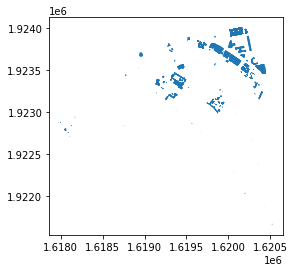

In [674]:
mdf.plot()

In [675]:
type(mdf)

geopandas.geodataframe.GeoDataFrame

In [676]:
mdf.crs


<Derived Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [677]:
mdf.columns

Index(['xid_left', 'n_points', 'Max_HOUSE__left', 'grid_bldg_area_left',
       'geometry', 'index_right', 'xid_right', 'Max_HOUSE__right',
       'grid_bldg_area_right', 'centroid', 'distance', 'target_x', 'target_y',
       'neighbor_x', 'neighbor_y', 'angle_in_degrees', 'direction',
       'neighbor_volume'],
      dtype='object')

In [ ]:
cents_ns, cents_ew, avgsa, nbarea, mean_ht_out, std_ht_out, awmh_out

In [ ]:
average_north_south_building_distances, average_east_west_building_distances, average_building_area, footprint_building_areas, average_building_heights, standard_deviation_building_heights, area_weighted_average_building_heights


In [653]:
awmh_out[:10], area_weighted_average_building_heights[:10]

([0.0,
  2.3276996996996995,
  2.399764705882353,
  2.399764705882353,
  0.0,
  22.250012153380624,
  12.915654699779944,
  11.87926545503455,
  12.565421643659253,
  17.6147326651613],
 [0.0,
  2.3276996996996995,
  2.399764705882353,
  2.399764705882353,
  0.0,
  25.41,
  11.99,
  12.58,
  11.862382412007188,
  12.0])

In [646]:
for i in nbarea.keys():
    if i <= 10:
        print(f"{i}: {nbarea[i]}")
    else:
        break

1: ['0.00000000000', 52.0]
2: ['0.00000000000', 416.25]
3: ['2.66000000000', 403.75]
4: ['2.66000000000', 403.75]
5: ['0.00000000000', 70.75]
6: ['25.41000000000', 9364.25]
7: ['11.99000000000', 14314.25]
8: ['12.58000000000', 11423.25]
9: ['12.00000000000', 13018.5]
10: ['12.00000000000', 13221.5]


In [645]:
for i in footprint_building_areas.keys():
    if i <= 10:
        print(f"{i}: {footprint_building_areas[i]}")
    else:
        break

1: [0.0, 52.0]
2: [0.0, 416.25]
3: [2.66, 403.75]
4: [2.66, 403.75]
5: [0.0, 70.75]
6: [25.41, 8272.25]
7: [11.99, 11274.25]
8: [12.58, 5377.0]
9: [12.0, 4730.5]
10: [12.0, 4306.75]


In [470]:
# get a count of the number of points in each polygon
gdf['n_points'] = gdf.geometry.exterior.apply(count_points_in_polygon)


In [471]:
gxf = gdf[["xid", "n_points", height_field, "grid_bldg_area", "geometry"]].copy()

In [472]:
gxf.head()

,xid,n_points,Max_HOUSE_,grid_bldg_area,geometry
0,1,9,0.00,12.50,"POLYGON ((1618111.652 1922706.443, 1618109.381..."
1,2,7,0.00,39.50,"POLYGON ((1618092.351 1922752.255, 1618088.410..."
2,3,22,2.66,326.50,"POLYGON ((1618052.020 1922797.834, 1618051.749..."
3,4,5,2.66,37.75,"POLYGON ((1618059.647 1922806.024, 1618058.415..."
4,5,19,0.00,70.75,"POLYGON ((1617996.818 1922869.925, 1617997.292..."


<AxesSubplot:>

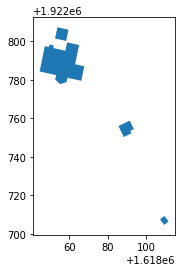

In [473]:
gdf.iloc[0:4].geometry.plot()

<AxesSubplot:>

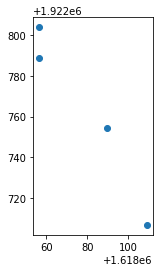

In [474]:
gdf.iloc[0:4].geometry.centroid.plot()

<AxesSubplot:>

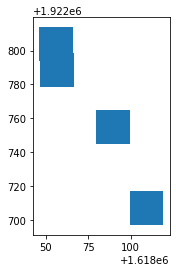

In [666]:
# Note cap_style: round = 1, flat = 2, square = 3
# buffer = points.buffer(2, cap_style = 3)

gdf.iloc[0:4].geometry.centroid.buffer(10, cap_style=3).plot()

In [476]:
# when using a 100 pixel radius to square buffer there can only be a near centroid intersecting at the hypotenuse of a quadrant
max_hypotenuse = np.sqrt(100**2 + 100**2)

max_hypotenuse


141.4213562373095

In [477]:
gxf.head()

,xid,n_points,Max_HOUSE_,grid_bldg_area,geometry
0,1,9,0.00,12.50,"POLYGON ((1618111.652 1922706.443, 1618109.381..."
1,2,7,0.00,39.50,"POLYGON ((1618092.351 1922752.255, 1618088.410..."
2,3,22,2.66,326.50,"POLYGON ((1618052.020 1922797.834, 1618051.749..."
3,4,5,2.66,37.75,"POLYGON ((1618059.647 1922806.024, 1618058.415..."
4,5,19,0.00,70.75,"POLYGON ((1617996.818 1922869.925, 1617997.292..."


In [478]:
gbf = gxf.copy()
gbf["geometry"] =  gbf.geometry.centroid.buffer(100, cap_style=3)

gbf.head()


,xid,n_points,Max_HOUSE_,grid_bldg_area,geometry
0,1,9,0.00,12.50,"POLYGON ((1618209.423 1922806.987, 1618209.423..."
1,2,7,0.00,39.50,"POLYGON ((1618189.687 1922854.657, 1618189.687..."
2,3,22,2.66,326.50,"POLYGON ((1618156.329 1922888.642, 1618156.329..."
3,4,5,2.66,37.75,"POLYGON ((1618156.162 1922903.767, 1618156.162..."
4,5,19,0.00,70.75,"POLYGON ((1618097.945 1922974.311, 1618097.945..."


In [479]:
gpt = gxf[["xid", height_field, "grid_bldg_area", "geometry"]].copy()
gpt["geometry"] = gpt.geometry.centroid

gpt.head()


,xid,Max_HOUSE_,grid_bldg_area,geometry
0,1,0.00,12.50,POINT (1618109.423 1922706.987)
1,2,0.00,39.50,POINT (1618089.687 1922754.657)
2,3,2.66,326.50,POINT (1618056.329 1922788.642)
3,4,2.66,37.75,POINT (1618056.162 1922803.767)
4,5,0.00,70.75,POINT (1617997.945 1922874.311)


In [500]:
mdf = gpd.sjoin(gbf, gpt, how="inner", predicate='intersects')

# modified height field names after merge
target_height_field = f"{height_field}_left"
neighbor_height_field = f"{height_field}_right"


In [503]:
mdf.loc[mdf["xid_left"] == 1]

,xid_left,n_points,Max_HOUSE__left,grid_bldg_area_left,geometry,index_right,xid_right,Max_HOUSE__right,grid_bldg_area_right
0,1,9,0.0,12.5,"POLYGON ((1618209.423 1922806.987, 1618209.423...",0,1,0.00,12.50
0,1,9,0.0,12.5,"POLYGON ((1618209.423 1922806.987, 1618209.423...",1,2,0.00,39.50
0,1,9,0.0,12.5,"POLYGON ((1618209.423 1922806.987, 1618209.423...",2,3,2.66,326.50
0,1,9,0.0,12.5,"POLYGON ((1618209.423 1922806.987, 1618209.423...",3,4,2.66,37.75


In [504]:
# get the regular geometry for each building
xid_to_building_polygon = gxf.set_index("xid").geometry.to_dict()


In [505]:
# add it in place of the buffered geometry
mdf["geometry"] = mdf["xid_left"].map(xid_to_building_polygon)


In [506]:
# add in the centroid geometry of each intersecting building from the buffer proximity analysis
xid_to_neighbor_centroid = gpt.set_index("xid").geometry.to_dict()

mdf["centroid"] = gpd.GeoSeries(mdf["xid_right"].map(xid_to_neighbor_centroid), crs=mdf.crs)


/Users/d3y010/.pyenv/versions/3.9.4/envs/py3.9.4_naturf/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [507]:
mdf.loc[mdf["xid_left"] == 1]

,xid_left,n_points,Max_HOUSE__left,grid_bldg_area_left,geometry,index_right,xid_right,Max_HOUSE__right,grid_bldg_area_right,centroid
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",0,1,0.00,12.50,POINT (1618109.423 1922706.987)
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",1,2,0.00,39.50,POINT (1618089.687 1922754.657)
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",2,3,2.66,326.50,POINT (1618056.329 1922788.642)
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",3,4,2.66,37.75,POINT (1618056.162 1922803.767)


In [508]:
# calculate the distance from the target building to each neighbor
mdf["distance"] = mdf.geometry.centroid.distance(mdf["centroid"])


In [509]:
mdf.loc[mdf["xid_left"] == 1]


,xid_left,n_points,Max_HOUSE__left,grid_bldg_area_left,geometry,index_right,xid_right,Max_HOUSE__right,grid_bldg_area_right,centroid,distance
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",0,1,0.00,12.50,POINT (1618109.423 1922706.987),0.000000
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",1,2,0.00,39.50,POINT (1618089.687 1922754.657),51.593756
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",2,3,2.66,326.50,POINT (1618056.329 1922788.642),97.398702
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",3,4,2.66,37.75,POINT (1618056.162 1922803.767),110.467540


In [510]:
# generate the x, y of both target and neighboring buidings
mdf["target_x"] = mdf.geometry.centroid.x
mdf["target_y"] = mdf.geometry.centroid.y
mdf["neighbor_x"] = mdf["centroid"].x
mdf["neighbor_y"] = mdf["centroid"].y


In [511]:
# calculate the angle in degrees of the neighbor building orientation to the target
mdf["angle_in_degrees"] = np.degrees(np.arctan2(mdf["neighbor_y"] - mdf["target_y"], mdf["neighbor_x"] - mdf["target_x"]))

# adjust the angle to correspond to a circle where 0/360 degrees is directly east, and the degrees increase counter-clockwise
mdf["angle_in_degrees"] = np.where(mdf["angle_in_degrees"] < 0, 
                                   mdf["angle_in_degrees"] + DEGREES_IN_CIRCLE, 
                                   mdf["angle_in_degrees"])


In [512]:
# initialize direction field as string
mdf["direction"] = ""

# identify eastern orientation
mdf["direction"] = np.where((((SOUTHEAST_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] <= DEGREES_IN_CIRCLE)) 
                            | ((START_OF_CIRCLE_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] < NORTHEAST_DEGREES)))
                            | ((NORTHWEST_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] < SOUTHWEST_DEGREES)),
                           "east_west",
                           mdf["direction"])

# # identify western orientation
# mdf["direction"] = np.where((NORTHWEST_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] < SOUTHWEST_DEGREES),
#                            "west",
#                            mdf["direction"])

# identify northern orientation
mdf["direction"] = np.where(((NORTHEAST_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] < NORTHWEST_DEGREES))
                            | ((SOUTHWEST_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] < SOUTHEAST_DEGREES)),
                           "north_south",
                           mdf["direction"])


# # identify southern orientation
# mdf["direction"] = np.where((SOUTHWEST_DEGREES <= mdf["angle_in_degrees"]) & (mdf["angle_in_degrees"] < SOUTHEAST_DEGREES),
#                            "south",
#                            mdf["direction"])


In [513]:
mdf.loc[mdf["xid_left"] == 1]


,xid_left,n_points,Max_HOUSE__left,grid_bldg_area_left,geometry,index_right,xid_right,Max_HOUSE__right,grid_bldg_area_right,centroid,distance,target_x,target_y,neighbor_x,neighbor_y,angle_in_degrees,direction
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",0,1,0.00,12.50,POINT (1618109.423 1922706.987),0.000000,1.618109e+06,1.922707e+06,1.618109e+06,1.922707e+06,0.000000,east_west
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",1,2,0.00,39.50,POINT (1618089.687 1922754.657),51.593756,1.618109e+06,1.922707e+06,1.618090e+06,1.922755e+06,112.489477,north_south
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",2,3,2.66,326.50,POINT (1618056.329 1922788.642),97.398702,1.618109e+06,1.922707e+06,1.618056e+06,1.922789e+06,123.032756,north_south
0,1,9,0.0,12.5,"POLYGON ((1618111.652 1922706.443, 1618109.381...",3,4,2.66,37.75,POINT (1618056.162 1922803.767),110.467540,1.618109e+06,1.922707e+06,1.618056e+06,1.922804e+06,118.824970,north_south


In [515]:
# calculates the area of all buildings within the plan area
plan_area_dict = mdf.groupby("xid_left")["grid_bldg_area_right"].sum().to_dict()


In [516]:
# building height
building_height_dict = mdf.groupby("xid_left")[target_height_field].max().to_dict()


In [517]:
# add the height and plan_area to a dictonary where the key is the target building ID
footprint_building_areas = {}
for i in plan_area_dict.keys():
    footprint_building_areas[i] = [building_height_dict[i], plan_area_dict[i]]


In [520]:
average_building_heights = mdf.groupby("xid_left")[neighbor_height_field].mean().tolist()

standard_deviation_building_heights = mdf.groupby("xid_left")[neighbor_height_field].std().tolist()


In [529]:
average_direction_distance = mdf.groupby(["xid_left", "direction"])["distance"].mean().reset_index()
average_north_south_building_distances = average_direction_distance.loc[average_direction_distance["direction"] == "north_south"][["xid_left", "distance"]].set_index("xid_left").to_dict()["distance"]
average_east_west_building_distances = average_direction_distance.loc[average_direction_distance["direction"] == "east_west"][["xid_left", "distance"]].set_index("xid_left").to_dict()["distance"]


,xid_left,direction,distance
0,1,east_west,0.000000
1,1,north_south,86.486666
2,2,east_west,0.000000
3,2,north_south,62.721452
4,3,east_west,44.489205
...,...,...,...
492,258,east_west,17.472561
493,258,north_south,85.311323
494,259,east_west,0.000000
495,260,east_west,55.640023


In [536]:
mdf.columns

Index(['xid_left', 'n_points', 'Max_HOUSE__left', 'grid_bldg_area_left',
       'geometry', 'index_right', 'xid_right', 'Max_HOUSE__right',
       'grid_bldg_area_right', 'centroid', 'distance', 'target_x', 'target_y',
       'neighbor_x', 'neighbor_y', 'angle_in_degrees', 'direction'],
      dtype='object')

In [537]:
mdf["neighbor_volume"] = mdf["grid_bldg_area_right"] * mdf[neighbor_height_field]

area_weighted_average_building_heights = ((mdf.groupby("xid_left")["neighbor_volume"].sum()) / 
                                          (mdf.groupby("xid_left")["grid_bldg_area_right"].sum())
                                         ).replace([np.inf, -np.inf], 0).fillna(0).to_list()

# average of all of the building surface areas in the shapefile
average_building_area = mdf.groupby("xid_left")["grid_bldg_area_left"].max().mean()


In [591]:
i2arr = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
dils = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
narr = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
struct = ndimage.generate_binary_structure(2, 2)
RADIUS = 100
NORTHWEST_DEGREES = 135
NORTHEAST_DEGREES = 45
SOUTHWEST_DEGREES = 225
SOUTHEAST_DEGREES = 315
DEGREES_IN_CIRCLE = 360
START_OF_CIRCLE_DEGREES = 0
sumareas = 0
counter = 1

average_north_south_building_distances = {}
average_east_west_building_distances = {}
average_building_heights = []
standard_deviation_building_heights = []
area_weighted_average_building_heights = []
footprint_building_areas = {}


In [654]:
def avg_building_dist(IMAGE_SIZE_X, IMAGE_SIZE_Y, layer2, ids, PIXEL_SIZE, height_field, heights, areas, centroids):
    '''
    Loops through all the buildings in the shapefile to calculate distances between buildings and other information used in
    calculating urban parameters. Calculates urban parameters 92-94.

    Parameters
    ----------
    IMAGE_SIZE_X : int
        Length of the shapefile in the x-direction.
    IMAGE_SIZE_Y : int
        Length of the shapefile in the y-direction.
    layer2 : osgeo.ogr.Layer
        The target layer of the shapefile, automatically generated in Parameter_Calulcations.py.
    ids : numpy.ndarray
        Array where the buildings in the shapefile are represented by unique ids, automatically generated in Parameter_Calulcations.py.
    PIXEL_SIZE : float
        Pixel size of the building raster.
    height_field : str
        Name of height field in the shapefile.
    heights : dict
        Height of every building in the shapefile.
    areas : dict
        Area of every building in the shapefile.
    centroids : dict
        Centroid of every building in the shapefile.

    Returns
    ----------
    average_north_south_building_distances : dict
        Average north/south distance from each building to every other building.
    average_east_west_building_distances : dict
        Average east/west distance from each building to every other building.
    average_building_area : float
        Average building area for the shapefile.
    footprint_building_areas : dict
        Height and building footprint areas within the plan area for each building.
    average_building_heights : list
        Average height of the buildings.
    standard_deviation_building_heights : list
        Standard deviation of heights of the buildings.
    area_weighted_average_building_heights : list
        Area-weighted mean building heights.

    '''

    i2arr = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
    dils = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
    narr = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
    struct = ndimage.generate_binary_structure(2, 2)
    RADIUS = 100
    NORTHWEST_DEGREES = 135
    NORTHEAST_DEGREES = 45
    SOUTHWEST_DEGREES = 225
    SOUTHEAST_DEGREES = 315
    DEGREES_IN_CIRCLE = 360
    START_OF_CIRCLE_DEGREES = 0
    sumareas = 0
    counter = 1
    average_north_south = 0
    average_east_west = 0

    average_north_south_building_distances = {}
    average_east_west_building_distances = {}
    average_building_heights = []
    standard_deviation_building_heights = []
    area_weighted_average_building_heights = []
    footprint_building_areas = {}
    
    target_to_neighbors = {}

    layer2.ResetReading()
    feature_buil = layer2.GetNextFeature()

    while feature_buil:
        height = feature_buil.GetFieldAsString(height_field)

        average_north_south = 0
        average_east_west = 0

        sumarhts = 0
        sumareas2 = 0

        current_building_heights = []

        if height != '':

            geomb = feature_buil.GetGeometryRef()
            ring = geomb.GetGeometryRef(0)
            numpoints = ring.GetPointCount()

            if numpoints != 0:

                i2arr.fill(0)
                dils.fill(0)
                narr.fill(0)
                if len(ids[ids == counter]) != 0:
                    i2arr[ids == counter] = 1 # Puts a 1 wherever the current counter corresponds with the IDs file
                    builarea = sum(i2arr) * PIXEL_SIZE**2 # Sums up the 1s and multiplies by the pixel area to get the current building area
                    i2arr = ndimage.binary_dilation(i2arr, structure=struct, iterations=RADIUS).astype(i2arr.dtype) # Dilates the i2arr to get a square with radius 100 pixels
                    building_ids = unique(ids[where(i2arr == 1)]) # A list of the unique building IDs found in the current dilated area
                    sumareas += builarea

                    if len(building_ids) != 0:
                        currcx = centroids[counter][0] # current building centroid x coordinate
                        currcy = centroids[counter][1] # current building centroid y coordinate

                        te, tn, ts, tw = 0., 0., 0., 0.
                        ce, cn, cs, cw = 0., 0., 0., 0.
                        
                        for building_id in building_ids: # loops through every building and calculates the distance and angle from that building to all other buildings
                            
                            target_to_neighbors[counter] = building_ids
                            
                            if building_id != 0 and building_id in heights: # Checks that the unique ID is not 0 (because height indexing begins at 1) and that it is in the heights list
                                current_building_heights.append(heights[building_id]) # Appends the current building height to the current_building_heights list
                                dils[(ids == building_id) & (i2arr == 1)] = 1 # Creates an array with 1s where the current ID is within the dilated area

                                sumarhts += areas[building_id] * heights[building_id] # Multiplies the current building area and height together, and then adds it to a rolling sum for the tile
                                sumareas2 += areas[building_id] # Adds the current building height to a rolling sum
                                #print("counter", counter)

                                if building_id != counter: # Loops through every building except for the current one
                                    cx = centroids[building_id][0] # The centroid x coordinate of the other building
                                    cy = centroids[building_id][1] # The centroid y coordinate of the other building
                                    d = math.hypot((currcx - cx), (currcy - cy)) # The distance between the two centroids
                                    angle = ang2points(currcx, currcy, cx, cy) # The angle for the y coordinate
                                    
                                    # The angles correspond to a circle where 0/360 degrees is directly east, and the degrees increase counter-clockwise
                                    if (SOUTHEAST_DEGREES <= angle <= DEGREES_IN_CIRCLE or START_OF_CIRCLE_DEGREES <= angle < NORTHEAST_DEGREES) and d != 0:  # east
                                        te += d
                                        ce += 1
                                    elif NORTHWEST_DEGREES <= angle < SOUTHWEST_DEGREES and d != 0:  # west
                                        tw += d
                                        cw += 1
                                    elif NORTHEAST_DEGREES <= angle < NORTHWEST_DEGREES and d != 0:  # north
                                        tn += d
                                        cn += 1
                                    elif SOUTHWEST_DEGREES <= angle < SOUTHEAST_DEGREES and d != 0:  # south 
                                        ts += d
                                        cs += 1
                                    else:
                                        raise Exception("Angle isn't between 0 and 360.")

                        if cn != 0 or cs != 0:
                            average_north_south = (tn + ts) / (cn + cs) # The mean north and south distance from the current building to all other buildings
                        else:
                            average_north_south = 0

                        if ce != 0 or cw != 0:
                            average_east_west = (te + tw) / (ce + cw) # The mean west and east distance from the current building to all other buildings
                        else:
                            average_east_west = 0

                        narr[(dils == 1) & (i2arr == 1)] = 1 # Creates an array with 1s only where the buildings are
                        plan_area = sum(narr) * PIXEL_SIZE**2 # Calculates the area of all buildings within the plan area 

                        footprint_building_areas[counter] = [height, plan_area]  # Creates a dictionary where the counter corresponds to the height and plan area of each building

            if len(current_building_heights) != 0:
                current_building_heights = array(current_building_heights)
                average_building_heights.append(current_building_heights.mean())
                standard_deviation_building_heights.append(current_building_heights.std())
            else:
                average_building_heights.append(height)

                # TODO:  wouldn't the standard deviation of a single value be 0 and not the value itself?
                standard_deviation_building_heights.append(height)

            average_north_south_building_distances[counter] = average_north_south
            average_east_west_building_distances[counter] = average_east_west

            if sumareas2 != 0:
                area_weighted_average_building_heights.append(sumarhts / sumareas2)
            else:
                area_weighted_average_building_heights.append(0)

        counter += 1

        feature_buil.Destroy()
        feature_buil = layer2.GetNextFeature()

    average_building_area = sumareas / counter  # sum of all of the surface areas in shapefile (used in a parameter)

    return average_north_south_building_distances, average_east_west_building_distances, average_building_area, footprint_building_areas, average_building_heights, standard_deviation_building_heights, area_weighted_average_building_heights, target_to_neighbors


In [655]:
%%time

output = avg_building_dist(IMAGE_SIZE_X=IMAGE_SIZE_X, 
                           IMAGE_SIZE_Y=IMAGE_SIZE_Y, 
                           layer2=layer2, 
                           ids=id_arr, 
                           PIXEL_SIZE=PIXEL_SIZE, 
                           height_field=height_field, 
                           heights=hts, 
                           areas=areas, 
                           centroids=cents)

cents_ns, cents_ew, avgsa, nbarea, mean_ht_out, std_ht_out, awmh_out, target_to_neighbors = output


CPU times: user 3min 58s, sys: 18.1 s, total: 4min 16s
Wall time: 4min 19s


Consider altering this where the target building does not get accounted for

In [ ]:
%%time

for building in range(1, 10 + 1, 1):

    average_north_south = 0
    average_east_west = 0

    sumarhts = 0
    sumareas2 = 0


    if counter in id_arr:

        print(f"building ID target:  {counter}")

        # place a 1 where building id equals the current count
        i2arr[id_arr == counter] = 1

        # current building area
        builarea = np.sum(i2arr) * PIXEL_SIZE**2
        print(f"builarea: {builarea}")

        # add the building area to the total building area for the file
        sumareas += builarea

        # dilate the building elements to get a square with radius 100 pixels
        i2arr = ndimage.binary_dilation(i2arr, structure=struct, iterations=RADIUS).astype(i2arr.dtype)

        # get a list of the build IDs found in the current buffer
        building_ids = np.unique(id_arr[i2arr == 1])

        # remove any 0 values
        building_ids = building_ids[building_ids > 0]

        # get the building coordinates 
        currcx, currcy = cents[counter]
        print(currcx, currcy)

        te, tn, ts, tw = 0., 0., 0., 0.
        ce, cn, cs, cw = 0., 0., 0., 0.

        for building_id in building_ids:

            print(building_id)

            # populate array with 1 for the current building ID where within the buffered area
            dils[(id_arr == building_id) & (i2arr == 1)] = 1

            # calculate building volume and add to tally
            sumarhts += areas[building_id] * hts[building_id]

            # tally building area
            sumareas2 += areas[building_id]

            # if building ID not the target building but is in the buffer
            if building_id != counter:

                # x, y coordinates of the centroid of the neighboring building
                cx, cy = cents[building_id]
                print(cx, cy)

                # distance between the centroid of the target building and the neighbor
                d = np.hypot((currcx - cx), (currcy - cy))

                print(f"distance: {d}")

                # angle of hypotenuse
                angle = angle_between_two_points(currcx, currcy, cx, cy)

                print(f"angle: {angle}")

                # the angles correspond to a circle where 0/360 degrees is directly east, and the degrees increase counter-clockwise
                if (SOUTHEAST_DEGREES <= angle <= DEGREES_IN_CIRCLE) or (START_OF_CIRCLE_DEGREES <= angle < NORTHEAST_DEGREES):  # east
                    te += d
                    ce += 1
                elif NORTHWEST_DEGREES <= angle < SOUTHWEST_DEGREES:  # west
                    tw += d
                    cw += 1
                elif NORTHEAST_DEGREES <= angle < NORTHWEST_DEGREES:  # north
                    tn += d
                    cn += 1
                elif SOUTHWEST_DEGREES <= angle < SOUTHEAST_DEGREES :  # south 
                    ts += d
                    cs += 1
                else:
                    raise AssertionError(f"Angle for building ID {counter} to ID {building_id} isn't between 0 and 360.")

            # calculate the number of north-south and east-west buildings from the target building
            number_north_south_buildings = cn + cs
            number_east_west_buildings = ce + cw

            # calculate average distances for each direction
            average_north_south = 0
            if number_north_south_buildings > 0:
                average_north_south += (tn + ts) / number_north_south_buildings

            average_east_west = 0
            if number_east_west_buildings > 0:
                average_east_west += (te + tw) / number_east_west_buildings

            print(f"average_north_south: {average_north_south}")
            print(f"average_east_west: {average_east_west}")

            # build an array with 1 where each building is
            narr[(dils == 1) & (i2arr == 1)] = 1

            # calculates the area of all buildings within the plan area
            plan_area = np.sum(narr) * PIXEL_SIZE**2

            print(f"plan_area: {plan_area}")

            # add the height and plan_area to a dictonary where the key is the target building ID
            footprint_building_areas[counter] = [hts[counter], plan_area] 

        # create a list of current building heights
        current_building_heights = np.array([hts[i] for i in building_ids])

        # append stats to summaries
        average_building_heights.append(current_building_heights.mean())
        standard_deviation_building_heights.append(current_building_heights.std())
        average_north_south_building_distances[counter] = average_north_south
        average_east_west_building_distances[counter] = average_east_west

        print(f"sumareas2: {sumareas2}")
        print(f"sumarhts: {sumarhts}")

        if sumareas2 > 0:

            area_weighted_average_building_heights.append(sumarhts / sumareas2)

        else:

            area_weighted_average_building_heights.append(0)

        # advance to next building
        counter += 1

# sum of all of the building surface areas in the shapefile
average_building_area = sumareas / counter

    

In [216]:
average_north_south_building_distances
average_east_west_building_distances
average_building_area
footprint_building_areas
average_building_heights
standard_deviation_building_heights
area_weighted_average_building_heights


[1.8101914992993928, 1.5640112994350281]

In [209]:
a = np.array([1.2])
np.mean(a), np.std(a)

(1.2, 0.0)

In [206]:
np.mean(current_building_heights)

1.064

In [174]:
SOUTHEAST_DEGREES, DEGREES_IN_CIRCLE, START_OF_CIRCLE_DEGREES, NORTHEAST_DEGREES, NORTHWEST_DEGREES, SOUTHWEST_DEGREES

(315, 360, 0, 45, 135, 225)

In [171]:
cx, cy

(1618056.1621925132, 1922803.7673784862)

In [173]:
if 

110.46754025381117

In [160]:
building_id = 4

In [161]:
areas[building_id] * hts[building_id]

100.415

In [158]:
areas[building_id]

12.5

In [159]:
hts[building_id]

0.0

In [150]:
dils[(id_arr == 2) & (i2arr == 1)] = 1

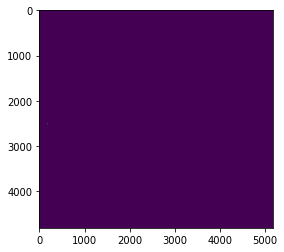

<AxesSubplot:>

In [151]:
show(dils)

#### ORIGINAL START

In [51]:
from osgeo import gdal, ogr
import math
from numpy import array, zeros, uint8, uint16, where, empty, sum, unique, rint, array_equiv
from skimage.draw import polygon
from scipy import ndimage
from osgeo.gdalconst import *
from PIL import Image


In [79]:
def get_cents_hts(IMAGE_SIZE_X, IMAGE_SIZE_Y, layer2, ids, PIXEL_SIZE, height_field):
    '''
    Loop through all buildings in the shapefile and append their centroids, heights, and areas to dictionaries.

    Parameters
    ----------
    IMAGE_SIZE_X : int
        Length of the shapefile in the x-direction.
    IMAGE_SIZE_Y : int
        Length of the shapefile in the y-direction.
    layer2 : osgeo.ogr.Layer
        The target layer of the shapefile, automatically generated in Parameter_Calulcations.py.
    ids : numpy.ndarray
        Array where the buildings in the shapefile are represented by unique ids, automatically generated in Parameter_Calulcations.py.
    PIXEL_SIZE : float
        Pixel size of the building raster.
    height_field : str
        Name of height field in study shapefile.

    Returns
    ----------
    centroids : dict
        Centroid of every building in the shapefile
    heights : dict
        Height of every building in the shapefile
    areas : dict
        Area of every building in the shapefile

    '''
    centroids = {}
    heights = {}
    areas = {}
    i2arr = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
    count = 1

    layer2.ResetReading()
    feature_buil = layer2.GetNextFeature()

    # todo: replace with for loop to remove count variable
    while feature_buil:
        height = feature_buil.GetFieldAsString(height_field)

        if height != '':
            height = float(height)
            heights[count] = height

            geom = feature_buil.GetGeometryRef()
            ring = geom.GetGeometryRef(0)
            numpoints = ring.GetPointCount()

            if numpoints != 0:

                cent = geom.Centroid()
                centx = cent.GetX()
                centy = cent.GetY()

                centx = float(centx)
                centy = float(centy)

                centroids[count] = [centx, centy]

                building_area = 0

                i2arr.fill(0)
                if len(ids[ids == count]) != 0:
                    i2arr[ids == count] = 1
                    building_area = sum(i2arr) * PIXEL_SIZE**2

                areas[count] = building_area

        count += 1

        feature_buil.Destroy()
        feature_buil = layer2.GetNextFeature()

    return centroids, heights, areas


def avg_building_dist(IMAGE_SIZE_X, IMAGE_SIZE_Y, layer2, ids, PIXEL_SIZE, height_field, heights, areas, centroids):
    '''
    Loops through all the buildings in the shapefile to calculate distances between buildings and other information used in
    calculating urban parameters. Calculates urban parameters 92-94.

    Parameters
    ----------
    IMAGE_SIZE_X : int
        Length of the shapefile in the x-direction.
    IMAGE_SIZE_Y : int
        Length of the shapefile in the y-direction.
    layer2 : osgeo.ogr.Layer
        The target layer of the shapefile, automatically generated in Parameter_Calulcations.py.
    ids : numpy.ndarray
        Array where the buildings in the shapefile are represented by unique ids, automatically generated in Parameter_Calulcations.py.
    PIXEL_SIZE : float
        Pixel size of the building raster.
    height_field : str
        Name of height field in the shapefile.
    heights : dict
        Height of every building in the shapefile.
    areas : dict
        Area of every building in the shapefile.
    centroids : dict
        Centroid of every building in the shapefile.

    Returns
    ----------
    average_north_south_building_distances : dict
        Average north/south distance from each building to every other building.
    average_east_west_building_distances : dict
        Average east/west distance from each building to every other building.
    average_building_area : float
        Average building area for the shapefile.
    footprint_building_areas : dict
        Height and building footprint areas within the plan area for each building.
    average_building_heights : list
        Average height of the buildings.
    standard_deviation_building_heights : list
        Standard deviation of heights of the buildings.
    area_weighted_average_building_heights : list
        Area-weighted mean building heights.

    '''

    i2arr = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
    dils = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
    narr = zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=uint8)
    struct = ndimage.generate_binary_structure(2, 2)
    RADIUS = 100
    NORTHWEST_DEGREES = 135
    NORTHEAST_DEGREES = 45
    SOUTHWEST_DEGREES = 225
    SOUTHEAST_DEGREES = 315
    DEGREES_IN_CIRCLE = 360
    START_OF_CIRCLE_DEGREES = 0
    sumareas = 0
    counter = 1
    average_north_south = 0
    average_east_west = 0

    average_north_south_building_distances = {}
    average_east_west_building_distances = {}
    average_building_heights = []
    standard_deviation_building_heights = []
    area_weighted_average_building_heights = []
    footprint_building_areas = {}

    layer2.ResetReading()
    feature_buil = layer2.GetNextFeature()

    while feature_buil:
        height = feature_buil.GetFieldAsString(height_field)

        average_north_south = 0
        average_east_west = 0

        sumarhts = 0
        sumareas2 = 0

        current_building_heights = []

        if height != '':

            geomb = feature_buil.GetGeometryRef()
            ring = geomb.GetGeometryRef(0)
            numpoints = ring.GetPointCount()

            if numpoints != 0:

                i2arr.fill(0)
                dils.fill(0)
                narr.fill(0)
                if len(ids[ids == counter]) != 0:
                    i2arr[ids == counter] = 1 # Puts a 1 wherever the current counter corresponds with the IDs file
                    builarea = sum(i2arr) * PIXEL_SIZE**2 # Sums up the 1s and multiplies by the pixel area to get the current building area
                    i2arr = ndimage.binary_dilation(i2arr, structure=struct, iterations=RADIUS).astype(i2arr.dtype) # Dilates the i2arr to get a square with radius 100 pixels
                    building_ids = unique(ids[where(i2arr == 1)]) # A list of the unique building IDs found in the current dilated area
                    sumareas += builarea

                    if len(building_ids) != 0:
                        currcx = centroids[counter][0] # current building centroid x coordinate
                        currcy = centroids[counter][1] # current building centroid y coordinate

                        te, tn, ts, tw = 0., 0., 0., 0.
                        ce, cn, cs, cw = 0., 0., 0., 0.
                        
                        for building_id in building_ids: # loops through every building and calculates the distance and angle from that building to all other buildings
                            if building_id != 0 and building_id in heights: # Checks that the unique ID is not 0 (because height indexing begins at 1) and that it is in the heights list
                                current_building_heights.append(heights[building_id]) # Appends the current building height to the current_building_heights list
                                dils[(ids == building_id) & (i2arr == 1)] = 1 # Creates an array with 1s where the current ID is within the dilated area

                                sumarhts += areas[building_id] * heights[building_id] # Multiplies the current building area and height together, and then adds it to a rolling sum for the tile
                                sumareas2 += areas[building_id] # Adds the current building height to a rolling sum
                                #print("counter", counter)
                                if building_id != counter: # Loops through every building except for the current one
                                    cx = centroids[building_id][0] # The centroid x coordinate of the other building
                                    cy = centroids[building_id][1] # The centroid y coordinate of the other building
                                    d = math.hypot((currcx - cx), (currcy - cy)) # The distance between the two centroids
                                    angle = ang2points(currcx, currcy, cx, cy) # The angle for the y coordinate
                                    
                                    # The angles correspond to a circle where 0/360 degrees is directly east, and the degrees increase counter-clockwise
                                    if (SOUTHEAST_DEGREES <= angle <= DEGREES_IN_CIRCLE or START_OF_CIRCLE_DEGREES <= angle < NORTHEAST_DEGREES) and d != 0:  # east
                                        te += d
                                        ce += 1
                                    elif NORTHWEST_DEGREES <= angle < SOUTHWEST_DEGREES and d != 0:  # west
                                        tw += d
                                        cw += 1
                                    elif NORTHEAST_DEGREES <= angle < NORTHWEST_DEGREES and d != 0:  # north
                                        tn += d
                                        cn += 1
                                    elif SOUTHWEST_DEGREES <= angle < SOUTHEAST_DEGREES and d != 0:  # south 
                                        ts += d
                                        cs += 1
                                    else:
                                        raise Exception("Angle isn't between 0 and 360.")

                        if cn != 0 or cs != 0:
                            average_north_south = (tn + ts) / (cn + cs) # The mean north and south distance from the current building to all other buildings
                        else:
                            average_north_south = 0

                        if ce != 0 or cw != 0:
                            average_east_west = (te + tw) / (ce + cw) # The mean west and east distance from the current building to all other buildings
                        else:
                            average_east_west = 0

                        narr[(dils == 1) & (i2arr == 1)] = 1 # Creates an array with 1s only where the buildings are
                        plan_area = sum(narr) * PIXEL_SIZE**2 # Calculates the area of all buildings within the plan area 

                        footprint_building_areas[counter] = [height, plan_area]  # Creates a dictionary where the counter corresponds to the height and plan area of each building

            if len(current_building_heights) != 0:
                current_building_heights = array(current_building_heights)
                average_building_heights.append(current_building_heights.mean())
                standard_deviation_building_heights.append(current_building_heights.std())
            else:
                average_building_heights.append(height)
                standard_deviation_building_heights.append(height)

            average_north_south_building_distances[counter] = average_north_south
            average_east_west_building_distances[counter] = average_east_west

            if sumareas2 != 0:
                area_weighted_average_building_heights.append(sumarhts / sumareas2)
            else:
                area_weighted_average_building_heights.append(0)

        counter += 1

        feature_buil.Destroy()
        feature_buil = layer2.GetNextFeature()

    average_building_area = sumareas / counter  # sum of all of the surface areas in shapefile (used in a parameter)

    return average_north_south_building_distances, average_east_west_building_distances, average_building_area, footprint_building_areas, average_building_heights, standard_deviation_building_heights, area_weighted_average_building_heights


def ang2lines(linea, lineb):
    """Finds the angle between two lines."""
    # returns [0, 360]
    DEGREES_IN_CIRCLE = 360

    va = [(linea[0][0]-linea[1][0]), (linea[0][1]-linea[1][1])]
    vb = [(lineb[0][0]-lineb[1][0]), (lineb[0][1]-lineb[1][1])]

    angle = math.atan2(va[1], va[0]) - math.atan2(vb[1], vb[0])
    angle *= DEGREES_IN_CIRCLE / (2 * math.pi)

    if angle < 0:
        angle += DEGREES_IN_CIRCLE

    return angle


def ang2points(x1, y1, x2, y2):
    """Finds the angle between two points."""
    DEGREES_IN_CIRCLE = 360

    dx = x2 - x1 # The distance between the x coordinates
    dy = y2 - y1 # The distance between the y coordinates

    angle_in_radians = math.atan2(dy, dx) # The angle facing the y coordinate (theta-y) in radians
    angle_in_degrees = math.degrees(angle_in_radians) # Theta-y in degrees

    if angle_in_degrees < 0:
        angle_in_degrees += DEGREES_IN_CIRCLE

    return angle_in_degrees

In [597]:
gdal.AllRegister()

In [598]:
# img = gdal.Open(x, gdal.GA_ReadOnly)

In [599]:
ids = Image.open(raster_ids_file)

In [600]:
ids = array(ids)

In [601]:
driver = ogr.GetDriverByName('ESRI Shapefile')

In [602]:
datasource2 = driver.Open(input_shapefile, 0)

In [603]:
layer2 = datasource2.GetLayer()

In [604]:
extent2 = layer2.GetExtent()
extent2

(1617992.0141000003, 1620526.423200001, 1921653.0683999993, 1924009.7564999992)

In [605]:
xOrigin = extent2[0]
yOrigin = extent2[3]

PIXEL_SIZE = 0.5

IMAGE_SIZE_X = (2 * math.ceil(extent2[3]-extent2[2])) + 100
IMAGE_SIZE_Y = (2 * math.ceil(extent2[1]-extent2[0])) + 100

pixelWidth = PIXEL_SIZE
pixelHeight = -PIXEL_SIZE

start_x = int(xOrigin)
start_y = math.ceil(yOrigin)

In [606]:
start_x_p = int((start_x - xOrigin) / pixelWidth)
start_y_p = int((start_y - yOrigin) / pixelHeight)

i2arr = np.zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y), dtype=np.uint8)

In [607]:
wi = math.hypot((extent2[0] - extent2[1]), (extent2[2] - extent2[3]))

he = math.hypot((extent2[0] - extent2[0]), (extent2[3] - extent2[2]))

car = wi / he

wi, he, car

(3460.8103511819004, 2356.688099999912, 1.468505888064708)

In [608]:
gdal.__version__

'2.1.3'

In [ ]:
# will not run due to geos
cents, hts, areas = get_cents_hts(IMAGE_SIZE_X, IMAGE_SIZE_Y, layer2, ids, PIXEL_SIZE, height_field)


In [ ]:
cents_ns, cents_ew, avgsa, nbarea, mean_ht_out, std_ht_out, awmh_out = avg_building_dist(IMAGE_SIZE_X, IMAGE_SIZE_Y, layer2, ids, PIXEL_SIZE, height_field, hts, areas, cents)


#### ORIGINAL END